In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lsst.sims.maf.db as db
from lsst.sims.maf.utils import m52snr
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.plots as plots

import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
from lsst.sims.utils import equatorialFromGalactic, hpid2RaDec, _healbin, healbin
from lsst.utils import getPackageDir
from mafContrib import MicrolensingMetric, generateMicrolensingSlicer, microlensing_amplification
import healpy as hp
import os

In [2]:
# generate a slicer with 10000 microlensing events
slicer = generateMicrolensingSlicer(min_crossing_time=1, max_crossing_time=10, n_events=10000)

/Users/yoachim/lsst/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/Users/yoachim/lsst/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/Users/yoachim/lsst/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/li

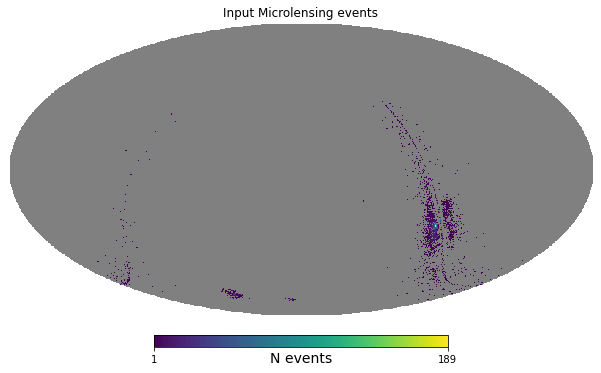

In [3]:
# We can reach into the slicer and plot up the distribution of things
dist = _healbin(slicer.slicePoints['ra'], slicer.slicePoints['dec'], slicer.slicePoints['dec']*0+1, reduceFunc=np.sum)
hp.mollview(dist, title='Input Microlensing events', unit='N events')

In [4]:
runName = 'baseline_v1.5_10yrs' 
opsdb = db.OpsimDatabase(runName+'.db')
outDir = 'temp'
resultsDb = db.ResultsDb(outDir=outDir)

metric = MicrolensingMetric()
sql = ''
# Don't want to try and plot N individual points, 
plotDict = {'reduceFunc': np.sum, 'nside': 64}
plotFuncs = [plots.HealpixSkyMap()]
summaryMetrics=[metrics.MeanMetric(maskVal=0)]
bundle = metricBundles.MetricBundle(metric, slicer, sql, runName=runName,
                                    plotDict=plotDict, plotFuncs=plotFuncs,
                                    summaryMetrics=summaryMetrics)
bundleDict = {'microlensing': bundle}

Querying database SummaryAllProps with no constraint for columns ['night', 'fieldRA', 'observationStartMJD', 'fiveSigmaDepth', 'filter', 'fieldDec'].
Found 2224095 visits
Running:  ['microlensing']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.
Plotting complete.


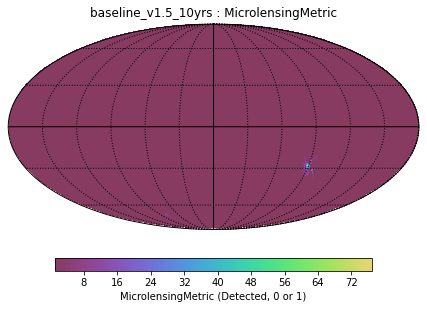

In [5]:
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

In [6]:
print('Fraction of events detected pre-peak=', bundle.summaryValues['Mean'])

Fraction of events detected pre-peak= 0.173


In [7]:
bundle.summaryValues

{'Mean': 0.173}

/Users/yoachim/lsst/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/Users/yoachim/lsst/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/Users/yoachim/lsst/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/li

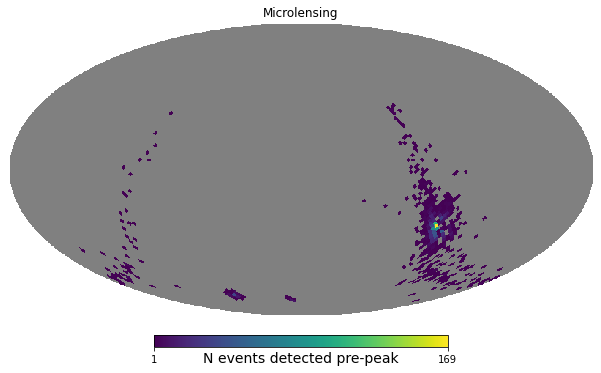

In [8]:
# Let's scale it a bit to make it easier to see
out_map = _healbin(slicer.slicePoints['ra'], slicer.slicePoints['dec'],
                   bundle.metricValues.data, nside=32, reduceFunc=np.sum)
out_map[np.where(out_map == 0)] = hp.UNSEEN
hp.mollview(out_map, unit='N events detected pre-peak', title='Microlensing')

In [9]:
# We can reach into the slicer and look at the light curve of one
slicer.slicePoints

{'sid': array([   0,    1,    2, ..., 9997, 9998, 9999]),
 'ra': array([4.67507783, 0.22887451, 4.70839448, ..., 4.83864435, 4.78704192,
        4.72954116]),
 'dec': array([-0.61092382, -1.27280782, -0.49984899, ..., -0.18904463,
        -0.48212348, -0.55237336]),
 'peak_time': array([1365.16262822, 1216.46206334,  644.13793455, ..., 1109.80311079,
        1619.56134366,  629.93883721]),
 'crossing_time': array([4.37086107, 9.55642876, 7.58794548, ..., 9.52037124, 4.57739193,
        2.95426364]),
 'impact_parameter': array([0.72999831, 0.184512  , 0.34663969, ..., 0.01945586, 0.40100484,
        0.25739798])}

## Example lightcurve

Text(0, 0.5, 'Amplitude')

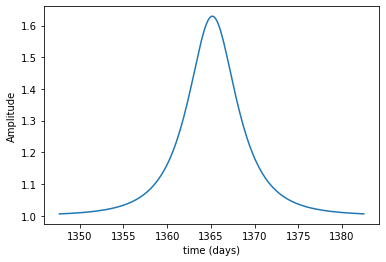

In [10]:
i=0
pt = slicer.slicePoints['peak_time'][i]
ct = slicer.slicePoints['crossing_time'][i]
t = np.arange(pt-ct*4, pt+ct*4, .2)

amp = microlensing_amplification(t, impact_parameter=slicer.slicePoints['impact_parameter'][i],
                                crossing_time=ct,
                                 peak_time=pt)
plt.plot(t, amp)
plt.xlabel('time (days)')
plt.ylabel('Amplitude')

## Put time in days before peak you would like the trigger criteria to be met

Querying database SummaryAllProps with no constraint for columns ['night', 'fieldRA', 'observationStartMJD', 'fiveSigmaDepth', 'filter', 'fieldDec'].
Found 2224095 visits
Running:  ['microlensing']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/Users/yoachim/lsst/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(


Plotting complete.


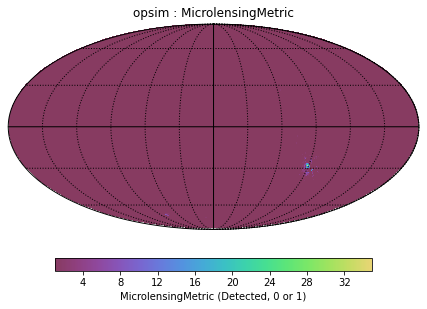

In [11]:
metric = MicrolensingMetric(time_before_peak = 10)

sql = ''
# Don't want to try and plot N individual points, 
plotDict = {'reduceFunc': np.sum, 'nside': 64}
plotFuncs = [plots.HealpixSkyMap()]
summaryMetrics=[metrics.MeanMetric(maskVal=0)]
bundle = metricBundles.MetricBundle(metric, slicer, sql,
                                    plotDict=plotDict, plotFuncs=plotFuncs,
                                    summaryMetrics=summaryMetrics)
bundleDict = {'microlensing': bundle}

bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

## Put detect = True if you would like both side of the light curve to be considered and increase the ptsNeeded on either side of the lightcurve

Querying database SummaryAllProps with no constraint for columns ['night', 'fieldRA', 'observationStartMJD', 'fiveSigmaDepth', 'filter', 'fieldDec'].
Found 2224095 visits
Running:  ['microlensing']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/Users/yoachim/lsst/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.4.1/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(


Plotting complete.


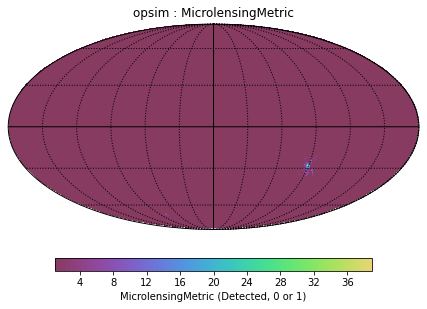

In [12]:
metric = MicrolensingMetric(detect = True, ptsNeeded = 4)

sql = ''
# Don't want to try and plot N individual points, 
plotDict = {'reduceFunc': np.sum, 'nside': 64}
plotFuncs = [plots.HealpixSkyMap()]
summaryMetrics=[metrics.MeanMetric(maskVal=0)]
bundle = metricBundles.MetricBundle(metric, slicer, sql,
                                    plotDict=plotDict, plotFuncs=plotFuncs,
                                    summaryMetrics=summaryMetrics)
bundleDict = {'microlensing': bundle}

bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

## It does not make sense to ask for a trigger before the peak if you want both sides of the lightcurve to be considered, so an error will be raised

In [13]:
metric = MicrolensingMetric(detect = True, time_before_peak = 10)

sql = ''
# Don't want to try and plot N individual points, 
plotDict = {'reduceFunc': np.sum, 'nside': 64}
plotFuncs = [plots.HealpixSkyMap()]
summaryMetrics=[metrics.MeanMetric(maskVal=0)]
bundle = metricBundles.MetricBundle(metric, slicer, sql,
                                    plotDict=plotDict, plotFuncs=plotFuncs,
                                    summaryMetrics=summaryMetrics)
bundleDict = {'microlensing': bundle}

bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

Querying database SummaryAllProps with no constraint for columns ['night', 'fieldRA', 'observationStartMJD', 'fiveSigmaDepth', 'filter', 'fieldDec'].
Found 2224095 visits
Running:  ['microlensing']


Exception: When detect = True, time_before_peak must be zero